# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 6 - RNNs



**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner


<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

<span style="color:red">**Model training can be very slow; start doing this HW early**</span>

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below.
- Please restart the kernel and run the entire notebook again before you submit.

**Names of person you have worked with goes here:**
<br><BR>

<div class="theme"> Overview: Named Entity Recognition Challenge</div>

Named entity recognition (NER) seeks to locate and classify named entities present in unstructured text into predefined categories such as organizations, locations, expressions of times, names of persons, etc. This technique is often used in real use cases such as classifying content for news providers, efficient search algorithms over large corpora and content-based recommendation systems. 

This represents an interesting "many-to-many" problem, allowing us to experiment with recurrent architectures and compare their performances against other models.


In [2]:
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

In [3]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend

from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, TimeDistributed, GRU, \
                          Dropout, Bidirectional, Conv1D, BatchNormalization

print(tf.keras.__version__)
print(tf.__version__)

2.2.4-tf
2.0.0


In [4]:
# Set seed for repeatable results
np.random.seed(123)
tf.random.set_seed(456)

<div class="theme"> Part 1: Data </div>
Read `HW6_data.csv` into a pandas dataframe using the provided code below.

In [5]:
# Given code
path_dataset = './data/HW6_data.csv'
data = pd.read_csv(path_dataset,
                   encoding="latin1")
data = data.fillna(method="ffill")
data.head(15)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [6]:
data['Sentence'] = data['Sentence #'].apply(lambda x: int(x.split(': ')[1])-1) # add a column for the sentence as numeric


As you can see, we have a dataset with sentences (```Sentence #``` column), each composed of words (```Word``` column) with part-of-speech tagging (```POS``` tagging) and inside–outside–beginning (IOB) named entity tags (```Tag``` column) attached. ```POS``` will not be used for this homework. We will predict ```Tag``` using only the words themselves.

Essential info about entities:
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

IOB prefix:
* B: beginning of named entity
* I: inside of named entity
* O: outside of named entity


<div class='exercise'><b> Question 1: Data [20 points total]</b></div>

**1.1** Create a list of unique words found in the 'Word' column and sort it in alphabetic order. Then append the special word "ENDPAD" to the end of the list, and assign it to the variable ```words```. Store the length of this list as ```n_words```. **Print your results for `n_words`**

**1.2** Create a list of unique tags and sort it in alphabetic order. Then append the special word "PAD" to the end of the list, and assign it to the variable ```tags```. Store the length of this list as ```n_tags```. **Print your results for `n_tags`**

**1.3** Process the data into a list of sentences where each sentence is a list of (word, tag) tuples. Here is an example of how the first sentence in the list should look:

[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
 
**1.4** Find out the number of words in the longest sentence, and store it to variable ```max_len```. **Print your results for `max_len`.**

**1.5** It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary.

**1.6** Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 

**1.7** Apply the keras ```pad_sequences``` function to standardize the predictors. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```. Run the provided cell to print your results. Your ```X[i]``` now should be something similar to this:

`[ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]`
 
**1.8** Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.

**1.9** Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.

**1.10** apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences'tags and length equal to ```max_length``` previously computed. 

**1.11** Use the ```to_categorical``` keras function to one-hot encode the tags. Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```. Run the provided cell to print your results.

**1.12** Split the dataset into train and test sets (test 10%).

## Answers

**1.1** Create a list of unique words found in the 'Word' column and sort it in alphabetic order. Then append the special word "ENDPAD" to the end of the list, and assign it to the variable ```words```. Store the length of this list as ```n_words```. **Print your results for `n_words`**

In [7]:
words = sorted(data.Word.unique())
words.append('ENDPAD')
n_words = len(words)

In [8]:
# Run this cell to show your results for n_words
print(n_words)

35179


**1.2** Create a list of unique tags and sort it in alphabetic order. Then append the special word "PAD" to the end of the list, and assign it to the variable ```tags```. Store the length of this list as ```n_tags```. **Print your results for `n_tags`**

In [9]:
tags = sorted(data.Tag.unique())
tags.append('PAD')
n_tags = len(tags)


In [10]:
# Run this cell to show your results for n_tags
print(n_tags)

18


**1.3** Process the data into a list of sentences where each sentence is a list of (word, tag) tuples. Here is an example of how the first sentence in the list should look:

[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
 

In [11]:
sentence_tuples = [list(zip(sentence[1]['Word'], sentence[1]['Tag'])) for sentence in data.groupby('Sentence')]
print(sentence_tuples[0])

[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


**1.4** Find out the number of words in the longest sentence, and store it to variable ```max_len```. **Print your results for `max_len`.**

In [12]:
max_len = data.groupby('Sentence #').size().sort_values().iloc[-1]

In [13]:
# Run this cell to show your results for max_len
print(max_len)

104


**1.5** It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary.

In [14]:
word2idx = dict(zip(words, np.arange(len(words))))
idx2word = {a:b for b,a in word2idx.items()}


**1.6** Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 

In [15]:
X = [[word2idx[word[0]] for word in sentence_tuple] for sentence_tuple in sentence_tuples]

**1.7** Apply the keras ```pad_sequences``` function to standardize the predictors. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```. Run the provided cell to print your results. Your ```X[i]``` now should be something similar to this:

`[ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]`

In [16]:
Z = [[1,2], [2,1,1,2]]
pad_sequences(Z, padding = 'post', value = 14)

array([[ 1,  2, 14, 14],
       [ 2,  1,  1,  2]], dtype=int32)

In [17]:
X = pad_sequences(X, padding = 'post', value = word2idx['ENDPAD'])

In [18]:
# Run this cell to show your results #
print("The index of word 'Harvard' is: {}\n".format(word2idx["Harvard"]))
print("Sentence 1: {}\n".format(X[1]))
print(X.shape)

The index of word 'Harvard' is: 7506

Sentence 1: [ 6283 27700 31967 25619 24853 33246 19981 25517 33246 29399 34878 19044
 18095 34971 32712 31830 17742     1  4114 11464 11631 14985     1 17364
     1 14484 33246  3881    24     1 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]

(47959, 104)


**1.8** Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.

In [19]:
tag2idx = dict(zip(tags, np.arange(len(tags))))
idx2tag = {a:b for b,a in tag2idx.items()}


**1.9** Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.

In [20]:
Y = [[tag2idx[tag[1]] for tag in sentence_tuple] for sentence_tuple in sentence_tuples]

**1.10** apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences'tags and length equal to ```max_length``` previously computed. 

In [21]:
Y = pad_sequences(Y, padding = 'post', value = tag2idx['PAD'])

**1.11** Use the ```to_categorical``` keras function to one-hot encode the tags. Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```. Run the provided cell to print your results.

In [22]:
Y = to_categorical(Y)

In [23]:
# Run this cell to show your results #
print("The index of tag 'B-gpe' is: {}\n".format(tag2idx["B-gpe"]))
print("The tag of the last word in Sentence 1: {}\n".format(Y[0][-1]))
print(np.array(Y).shape)

The index of tag 'B-gpe' is: 3

The tag of the last word in Sentence 1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

(47959, 104, 18)


**1.12** Split the dataset into train and test sets (test 10%).

In [24]:
np.random.seed(109)
n_sentences = len(data.Sentence.unique())
test_indices = np.sort(np.random.choice(np.arange(n_sentences), size = n_sentences//10, replace = False))
train_indices = np.sort([i for i in np.arange(n_sentences) if i not in test_indices])

In [25]:
X_tr = X[train_indices]
X_te = X[test_indices]
y_tr = Y[train_indices]
y_te = Y[test_indices]

## Part 2: Modelling

After preparing the train and test sets, we are ready to build five models: 
* frequency-based baseline 
* vanilla feedforward neural network
* recurrent neural network
* gated recurrent neural network
* bidirectional gated recurrent neural network

More details are given about architecture in each model's section. The input/output dimensionalities will be the same for all models:
* input: ```[# of sentences, max_len]```
* output: ```[# of sentences, max_len, n_tags]```

Follow the information in each model's section to set up the architecture of each model. And the end of each training, use the given ```store_model``` function to store the weights and architectures in the ```./models``` path for later testing;```load_keras_model()``` is also provided to you

A further ```plot_training_history``` helper function is given in case you need to check the training history.


In [26]:
# Store model
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./models/{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")
    
# Plot history
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [27]:
# Load model 
def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = tf.keras.models.model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./models/{}.h5".format(model_name))
    return model

<div class='exercise'><b>Question 2: Models [40 points total]</b></div>

**2.1** **Model 1: Baseline Model**

Predict the tag of a word simply with the most frequently-seen named entity tag of this word from the training set.

e.g. word "Apple" appears 10 times in the training set; 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, we predict it as "Corporate".

**Create an np.array ```baseline``` of length [n_words]**
where the ith element   ```baseline[i]``` is the index of the most commonly seen named entity tag of word i summarised from training set.   (e.g. [16, 16, 16, ..., 0, 16, 16])


**2.2** **Model 2: Vanilla Feed Forward Neural Network**

This model is provided for you. Please pay attention to the architecture of this neural network, especially the input/output dimensionalities and the Embedding layer.


**2.2a** Explain what the embedding layer is and why we need it here.

**2.2b** Explain why the Param # of Embedding layer is 1758950 (as shown in `print(model.summary())`).

**2.3** **Model 3: RNN**

Set up a simple RNN model by stacking the following layers in sequence:

    an input layer
    a simple Embedding layer transforming integer words into vectors
    a dropout layer to regularize the model
    a SimpleRNN layer
    a TimeDistributed layer with an inner Dense layer which output dimensionality is equal to n_tag
    
*(For hyperparameters, use those provided in Model 2)*

**2.3a** Define, compile, and train an RNN model. Use the provided code to save the model and plot the training history.

**2.3b** Visualize outputs from the SimpleRNN layer, one subplot for B-tags and one subplot for I-tags. Comment on the patterns you observed.

**2.4** **Model 4: GRU**

**2.4a** Briefly explain what a GRU is and how it's different from a simple RNN.

**2.4b** Define, compile, and train a GRU architecture by replacing the SimpleRNN cell with a GRU one. Use the provided code to save the model and plot the training history.

**2.4c** Visualize outputs from GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

**2.5** **Model 5: Bidirectional GRU**

**2.5a** Explain how a Bidirectional GRU differs from GRU model above.

**2.5b** Define, compile, and train a bidirectional GRU by wrapping your GRU layer in a Bidirectional one. Use the provided code to save the model and plot the training history.

**2.5c** Visualize outputs from bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

## Answers

**2.1** **Model 1: Baseline Model**

Predict the tag of a word simply with the most frequently-seen named entity tag of this word from the training set.

e.g. word "Apple" appears 10 times in the training set; 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, we predict it as "Corporate".

**Create an np.array ```baseline``` of length [n_words]**
where the ith element   ```baseline[i]``` is the index of the most commonly seen named entity tag of word i summarised from training set.   (e.g. [16, 16, 16, ..., 0, 16, 16])


In [28]:
sentence2idx = dict(zip(data['Sentence #'].unique(), np.arange(n_sentences)))
data['sentence_idx'] = data['Sentence #'].apply(lambda x: sentence2idx[x]) # assign an index to each sentence
data_train = data[data['sentence_idx'].isin(train_indices)]
data_test = data[data['sentence_idx'].isin(test_indices)]
train_words = data_train['Word'].unique() 

In [29]:
word_tag_counts = data_train.groupby('Word')['Tag'].value_counts()
baseline_tag = [word_tag_counts[word].index[0] if word in train_words else 'O' for word in words] # most frequent tag by word
baseline = np.array([tag2idx[i] for i in baseline_tag])


In [30]:
# Run this cell to show your results #
print(baseline[X].shape,'\n')
print('Sentence:\n {}\n'.format([idx2word[w] for w in X[0]]))
print('Predicted Tags:\n {}'.format([idx2tag[i] for i in baseline[X[0]]]))

(47959, 104) 

Sentence:
 ['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDP

**2.2** **Model 2: Vanilla Feed Forward Neural Network**

This model is provided for you. Please pay attention to the architecture of this neural network, especially the input/output dimensionalities and the Embedding layer.


### Use these hyperparameters for all NN models

In [31]:
n_units = 100
drop_rate = .1
dim_embed = 50

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

In [32]:
# Define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(tf.keras.layers.Dense(n_tags, activation="softmax"))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [33]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 50)           1758950   
_________________________________________________________________
dropout (Dropout)            (None, 104, 50)           0         
_________________________________________________________________
dense (Dense)                (None, 104, 18)           918       
Total params: 1,759,868
Trainable params: 1,759,868
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
# Train model
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38847 samples, validate on 4317 samples
Epoch 1/10
38847/38847 [==============================] - 18s 459us/sample - loss: 0.3147 - accuracy: 0.9788 - val_loss: 0.0598 - val_accuracy: 0.9858
Epoch 2/10
38847/38847 [==============================] - 15s 398us/sample - loss: 0.0513 - accuracy: 0.9864 - val_loss: 0.0482 - val_accuracy: 0.9869
Epoch 3/10
38847/38847 [==============================] - 16s 406us/sample - loss: 0.0448 - accuracy: 0.9873 - val_loss: 0.0454 - val_accuracy: 0.9875
Epoch 4/10
38847/38847 [==============================] - 16s 411us/sample - loss: 0.0425 - accuracy: 0.9878 - val_loss: 0.0442 - val_accuracy: 0.9877
Epoch 5/10
38847/38847 [==============================] - 16s 405us/sample - loss: 0.0412 - accuracy: 0.9882 - val_loss: 0.0434 - val_accuracy: 0.9879
Epoch 6/10
38847/38847 [==============================] - 16s 409us/sample - loss: 0.0404 - accuracy: 0.9884 - val_loss: 0.0431 - val_accuracy: 0.9880
Epoch 7/10
38847/38847 [=====================

In [35]:
store_keras_model(model, 'model_FFNN')

Saved model to disk


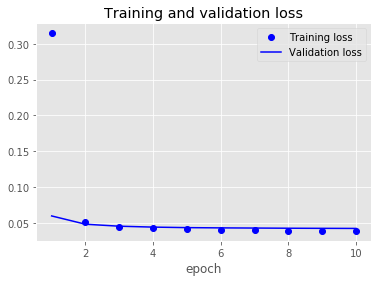

In [36]:
plot_training_history(history)

**2.2a** Explain what the embedding layer is and why we need it here.

We need an embedding layer is because it allows the model to take input data in a form that conveys similarity between words that have similar sentiments. If the input data were only one hot encoded, then the network would be very sparse (mostly 0s in the encoding and just one 1 for each word) and this requires a large amount of memory during training as well as does not minimize the number of parameters in the model.

**2.2b** Explain why the Param # of Embedding layer is 1758950 (as shown in `print(model.summary())`).

In [37]:
n_words*dim_embed

1758950

The parameter number of the embedding layer is equal to the number of words times the embedding dimension, as shown above. This is because each word is represented at a vector of length `n_words` which we represent as a dense vector of length `dim_embed`. To do this we multiply the one-hot vector by a matrix of size `n_words` $\times$ `dim_embed`, which explains the number of dimensions

### Viewing Hidden Layers
In addition to the final result, we also want to see the intermediate results from hidden layers. Below is an example showing how to get outputs from a hidden layer, and visualize them on the reduced dimension of 2D by PCA. (**Please note that this code and the parameters cannot be simply copied and pasted for other questions; some adjustments need to be made**) 

In [38]:
FFNN = load_keras_model("model_FFNN")
def create_truncated_model_FFNN(trained_model):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
    model.add(tf.keras.layers.Dropout(drop_rate))
    # set weights of first few layers using the weights of trained model
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model
truncated_model = create_truncated_model_FFNN(FFNN)
hidden_features = truncated_model.predict(X_te)

# flatten data
hidden_features = hidden_features.reshape(-1,50)
 
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance explained by PCA: 0.9407047017321251


In [39]:
# visualize hidden featurs on first two PCA components
# this plot only shows B-tags
def visualize_hidden_features(pca_result):
    color=['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_te.reshape(-1,18), axis=1)
    fig, ax = plt.subplots()
    fig.set_size_inches(6,6)    
    for cat in range(8):
        indices_B = np.where(category==cat)[0]
        #length=min(1000,len(indices_B))
        #indices_B=indices_B[:length]
        ax.scatter(pca_result[indices_B,0], pca_result[indices_B, 1], label=idx2tag[cat],s=2,color=color[cat],alpha=0.5)
        legend=ax.legend(markerscale=3)
        legend.get_frame().set_facecolor('w')  
    plt.show()

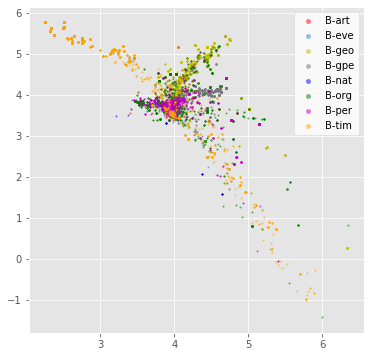

In [40]:
visualize_hidden_features(pca_result)

### Full function for other questions ###

In [41]:
def get_hidden_output_PCA(model,X_te,y_te,layer_index,out_dimension):
    output = tf.keras.backend.function([model.layers[0].input],[model.layers[layer_index].output])
    hidden_feature=np.array(output([X_te]))
    hidden_feature=hidden_feature.reshape(-1,out_dimension)
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(hidden_feature)
    print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
    return pca_result

In [42]:
def visualize_B_I(pca_result):
    color = ['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_te.reshape(-1,18), axis=1)
    fig, ax = plt.subplots(1,2) 
    fig.set_size_inches(12,6)
    for i in range(2):
        for cat in range(8*i,8*(i+1)):
            indices = np.where(category==cat)[0]
            ax[i].scatter(pca_result[indices,0], pca_result[indices, 1], label=idx2tag[cat],s=2,color=color[cat-8*i],alpha=0.5)
        legend = ax[i].legend(markerscale=3)
        legend.get_frame().set_facecolor('w') 
        ax[i].set_xlabel("first dimension")
        ax[i].set_ylabel("second dimension")
    fig.suptitle("visualization of hidden feature on reduced dimension by PCA")
    
    plt.show()

Variance explained by PCA: 0.9407051658905141


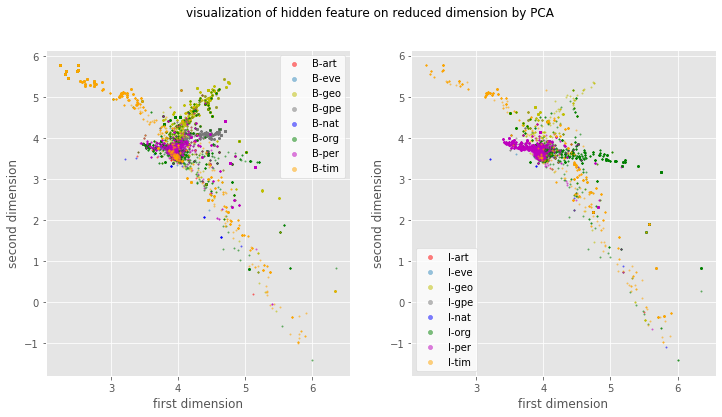

In [43]:
h = get_hidden_output_PCA(FFNN,X_te,y_te,1,50)
visualize_B_I(h)

**2.3** **Model 3: RNN**

Set up a simple RNN model by stacking the following layers in sequence:

    an input layer
    a simple Embedding layer transforming integer words into vectors
    a dropout layer to regularize the model
    a SimpleRNN layer
    a TimeDistributed layer with an inner Dense layer which output dimensionality is equal to n_tag
    
*(For hyperparameters, use those provided in Model 2)*

**2.3a** Define, compile, and train an RNN model. Use the provided code to save the model and plot the training history.

In [44]:
RNN = Sequential()
RNN.add(Embedding(n_words, dim_embed, input_length = max_len))
RNN.add(Dropout(drop_rate))
RNN.add(SimpleRNN(n_units, return_sequences = 1))
RNN.add(TimeDistributed(Dense(n_tags, activation = 'softmax')))
RNN.compile(optimizer = optimizer, loss = loss)

history = RNN.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split, verbose=verbose)

Train on 38847 samples, validate on 4317 samples
Epoch 1/10
38847/38847 [==============================] - 84s 2ms/sample - loss: 0.0921 - val_loss: 0.0329
Epoch 2/10
38847/38847 [==============================] - 81s 2ms/sample - loss: 0.0294 - val_loss: 0.0288
Epoch 3/10
38847/38847 [==============================] - 83s 2ms/sample - loss: 0.0261 - val_loss: 0.0279
Epoch 4/10
38847/38847 [==============================] - 82s 2ms/sample - loss: 0.0244 - val_loss: 0.0275
Epoch 5/10
38847/38847 [==============================] - 82s 2ms/sample - loss: 0.0233 - val_loss: 0.0274
Epoch 6/10
38847/38847 [==============================] - 82s 2ms/sample - loss: 0.0223 - val_loss: 0.0271
Epoch 7/10
38847/38847 [==============================] - 82s 2ms/sample - loss: 0.0214 - val_loss: 0.0271
Epoch 8/10
38847/38847 [==============================] - 82s 2ms/sample - loss: 0.0206 - val_loss: 0.0271
Epoch 9/10
38847/38847 [==============================] - 83s 2ms/sample - loss: 0.0198 - val_l

In [45]:
# save your mode #
store_keras_model(RNN, 'model_RNN')
RNN = load_keras_model("model_RNN")

Saved model to disk


In [46]:
RNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_2 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 104, 100)          15100     
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 18)           1818      
Total params: 1,775,868
Trainable params: 1,775,868
Non-trainable params: 0
_________________________________________________________________


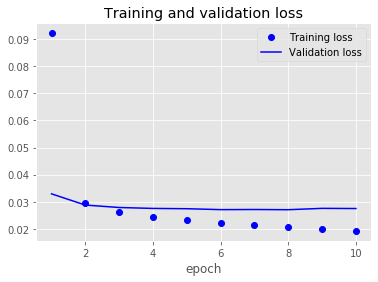

In [47]:
# run this cell to show your results #
plot_training_history(history)

**2.3b** Visualize outputs from the SimpleRNN layer, one subplot for B-tags and one subplot for I-tags. Comment on the patterns you observed.

Variance explained by PCA: 0.8272746161397989


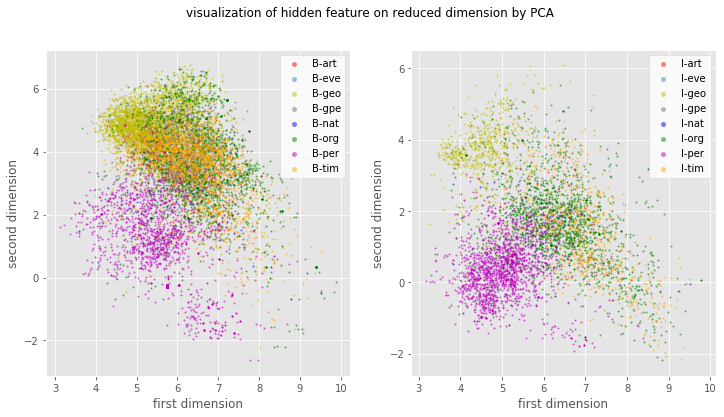

In [48]:
h = get_hidden_output_PCA(RNN,X_te,y_te,2,n_units)
visualize_B_I(h)

The clusters formed after PCA on the B-tags and I-tags show generally similar groupings. For example, the B-per tag data generally fall in the space with the first PC about 6 and the second PC about 1, while the I-per tag data generally fall in the space with the first PC about 5.5 and the second PC about 1. The B-tim data generally fall in the space with the first PC about 8 and the second PC about 3, while the I-tim data are centered around the space with first PC about 8 and the second PC about 2. The similar locations of clusters along the axes of the first two PCs indicates that clustering the data based on the B versus I tags does not materially change the identification of the essential info about the named entity (i.e., tag). However, the I-tags have more readily distinguishable clusters compared with the B-tags.

<div class='explication'> </div>

**2.4** **Model 4: GRU**

**2.4a** Briefly explain what a GRU is and how it's different from a simple RNN.

A GRU is a deviation of the vanilla RNN that attempts to remember information from the distant past by avoiding vanishing and exploding gradients. It uses two gates—an *update gate* and a *forget gate*. The update gate incorporates information from the present time and the most recent hidden state. The forget gate decides what information should remain from the previous state. The GRU then combines the output of these two gates to create a new hidden state. Unlike the simple RNN, the GRU updates updates the hidden state with addition, rather than multiplication, resulting in a more stable gradient.  

**2.4b** Define, compile, and train a GRU architecture by replacing the SimpleRNN cell with a GRU one. Use the provided code to save the model and plot the training history.

In [49]:
GRUmod = Sequential()
GRUmod.add(Embedding(n_words, dim_embed, input_length = max_len))
GRUmod.add(Dropout(drop_rate))
GRUmod.add(GRU(n_units, return_sequences = 1))
GRUmod.add(TimeDistributed(Dense(n_tags, activation = 'softmax')))
GRUmod.compile(optimizer = optimizer, loss = loss)

history = GRUmod.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split, verbose=verbose)

Train on 38847 samples, validate on 4317 samples
Epoch 1/10
38847/38847 [==============================] - 44s 1ms/sample - loss: 0.0893 - val_loss: 0.0321
Epoch 2/10
38847/38847 [==============================] - 39s 993us/sample - loss: 0.0289 - val_loss: 0.0285
Epoch 3/10
38847/38847 [==============================] - 38s 990us/sample - loss: 0.0258 - val_loss: 0.0272
Epoch 4/10
38847/38847 [==============================] - 39s 1ms/sample - loss: 0.0240 - val_loss: 0.0268
Epoch 5/10
38847/38847 [==============================] - 39s 994us/sample - loss: 0.0229 - val_loss: 0.0267
Epoch 6/10
38847/38847 [==============================] - 39s 1ms/sample - loss: 0.0219 - val_loss: 0.0264
Epoch 7/10
38847/38847 [==============================] - 39s 1000us/sample - loss: 0.0210 - val_loss: 0.0265
Epoch 8/10
38847/38847 [==============================] - 39s 1ms/sample - loss: 0.0202 - val_loss: 0.0264
Epoch 9/10
38847/38847 [==============================] - 39s 1ms/sample - loss: 0.019

In [50]:
# save your mode #
store_keras_model(GRUmod, 'model_GRU')
GRUmod = load_keras_model("model_GRU")

Saved model to disk


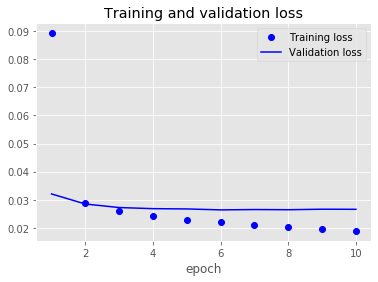

In [51]:
# run this cell to show your results #
plot_training_history(history)

In [52]:
# run this cell to show your results #
print(GRUmod.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_3 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
gru (GRU)                    (None, 104, 100)          45600     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 18)           1818      
Total params: 1,806,368
Trainable params: 1,806,368
Non-trainable params: 0
_________________________________________________________________
None


**2.4c** Visualize outputs from GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

Variance explained by PCA: 0.7733814424623531


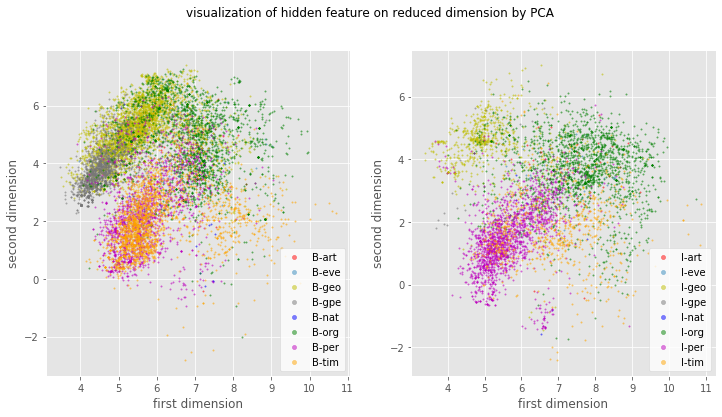

In [53]:
h = get_hidden_output_PCA(GRUmod,X_te,y_te,2,n_units)
visualize_B_I(h)

Just as in the PCA plots from the RNN generated previously, we observe that the I-tags (relative to the B-tags) are more readily distinguished from each other using the first two principal components. However, in the PCA plots generated from the hidden features from the GRU, we observe that the clusters are overall more clearly defined as they were in the PCA plots from the RNN. This indicates that the hidden features for the GRU layers capture more of the information for the tags in just the first two PCs. Since PCA is a linear dimensionality reduction method, the GRU's hidden features may also be capturing more of the linear relations in the tags since the PCA plot has more readily distinguished clusters.

**2.5** **Model 5: Bidirectional GRU**

**2.5a** Explain how a Bidirectional GRU differs from GRU model above.



A Bidirectional GRU is essentially a combination of two GRUs, one of which works forward and one of which works backward. The forward GRU processes the start of the first word of the sentence, feeds the hidden state to the second, and repeats until the end. The backward GRU does the same but in the reverse direction. For each word, the bidirectional GRU concatenates the hidden layer from the forward-GRU for that word and the hidden layer from the backward-GRU for that word, and passes that concatenation to the output layer. This differs from a single-directional GRU model in that it is able to incorporate information about a word using words *later* in the sentence, rather than just words that came before. 

**2.5b** Define, compile, and train a bidirectional GRU by wrapping your GRU layer in a Bidirectional one. Use the provided code to save the model and plot the training history.


In [54]:
BiGRUmod = Sequential()
BiGRUmod.add(Embedding(n_words, dim_embed, input_length = max_len))
BiGRUmod.add(Dropout(drop_rate))
BiGRUmod.add(Bidirectional(GRU(n_units, return_sequences = 1)))
BiGRUmod.add(TimeDistributed(Dense(n_tags, activation = 'softmax')))
BiGRUmod.compile(optimizer = optimizer, loss = loss)

history = BiGRUmod.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split, verbose=verbose)

Train on 38847 samples, validate on 4317 samples
Epoch 1/10
38847/38847 [==============================] - 75s 2ms/sample - loss: 0.0728 - val_loss: 0.0269
Epoch 2/10
38847/38847 [==============================] - 70s 2ms/sample - loss: 0.0241 - val_loss: 0.0236
Epoch 3/10
38847/38847 [==============================] - 70s 2ms/sample - loss: 0.0208 - val_loss: 0.0224
Epoch 4/10
38847/38847 [==============================] - 70s 2ms/sample - loss: 0.0189 - val_loss: 0.0222
Epoch 5/10
38847/38847 [==============================] - 71s 2ms/sample - loss: 0.0177 - val_loss: 0.0221
Epoch 6/10
38847/38847 [==============================] - 70s 2ms/sample - loss: 0.0166 - val_loss: 0.0217
Epoch 7/10
38847/38847 [==============================] - 70s 2ms/sample - loss: 0.0156 - val_loss: 0.0221
Epoch 8/10
38847/38847 [==============================] - 70s 2ms/sample - loss: 0.0146 - val_loss: 0.0222
Epoch 9/10
38847/38847 [==============================] - 70s 2ms/sample - loss: 0.0137 - val_l

In [55]:
# save your model #
store_keras_model(BiGRUmod, 'model_BiGRU')

Saved model to disk


In [56]:
# run this cell to show your results #
print(BiGRUmod.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_4 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 200)          91200     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 104, 18)           3618      
Total params: 1,853,768
Trainable params: 1,853,768
Non-trainable params: 0
_________________________________________________________________
None


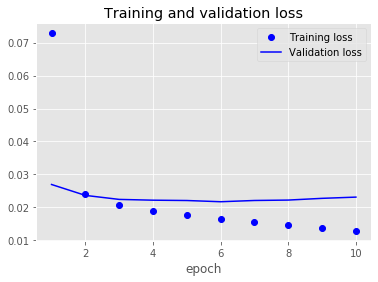

In [57]:
# run this cell to show your results #
plot_training_history(history)

**2.5c** Visualize outputs from bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

Variance explained by PCA: 0.7604033777222045


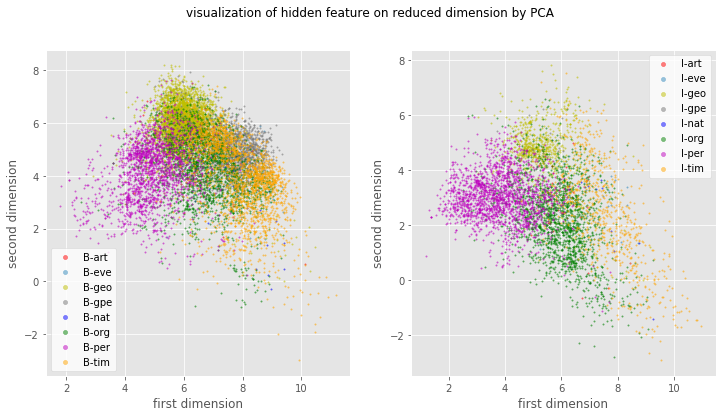

In [58]:
h = get_hidden_output_PCA(BiGRUmod,X_te,y_te,2,2*n_units)
visualize_B_I(h)

According to PCA of the BiGRU, the data are more readily distinguished when using the I-tags relative to using the B-tags. This is apparent by the PCA plots of the hidden features on the axes of the first two PCs, where the colored data are not as admixed on the right panel as they are on the left panel. However, both the B-tags and I-tags distinguish the data overall since there are distinctly colored clusters in both plots. The classes (e.g., I-per and B-per) are located in similar regions of space on the axes of the first two PCs for the B-tag and I-tag plots from the BiGRU shown above, as well as for the B-tag and I-tag plots from the RNN and GRU described previously. The data are overall more distinctly clustered by tag for the hidden features from the BiGRU compared with either the RNN or GRU, indicating that the BiGRU may be the most well-fit model of the ones studied here.

<div class='exercise'><b> Question 3: Analysis [40pt]</b></div>


**3.1** For each model, iteratively:

- Load the model using the given function ```load_keras_model```

- Apply the model to the test dataset

- Compute an F1 score for each ```Tag``` and store it 

**3.2** Plot the F1 score per Tag and per model making use of a grouped barplot.

**3.3** Briefly discuss the performance of each model


**3.4** Which tags have the lowest f1 score? For instance, you may find from the plot above that the test accuracy on "B-art", and "I-art" are very low (just an example, your case maybe different). Here is an example when models failed to predict these tags right

<img src="data/B_art.png" alt="drawing" width="600"/>

**3.5** Write functions to output another example in which the tags of the lowest accuracy was predicted wrong in a sentence (include both "B-xxx" and "I-xxx" tags). Store the results in a DataFrame (same format as the above example) and use styling functions below to print out your df.

**3.6** Choose one of the most promising models you have built, improve this model to achieve an f1 score higher than 0.8 for as many tags as possible (you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of NN, a different optimizer, etc.)

**3.7** Explain why you chose to change certain elements of the model and how effective these adjustments were.


## Answers

**3.1** For each model, iteratively:

- Load the model using the given function ```load_keras_model```

- Apply the model to the test dataset

- Compute an F1 score for each ```Tag``` and store it 

In [59]:
models = ['FFNN','RNN','GRU','BiGRU']
f1_scores = pd.DataFrame(columns = ['model','tag','score'])

for i, model_name in enumerate(models):
    model = load_keras_model('model_' + model_name)
    y_pred = to_categorical(model.predict_classes(X_te))
    for tag in range(n_tags):
        score = f1_score(y_te[:,:,tag].reshape(-1), y_pred[:,:,tag].reshape(-1))
        f1_scores.loc[len(f1_scores)] = [model_name,tag,score]

/usr/share/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


**3.2** Plot the F1 score per Tag and per model making use of a grouped barplot.

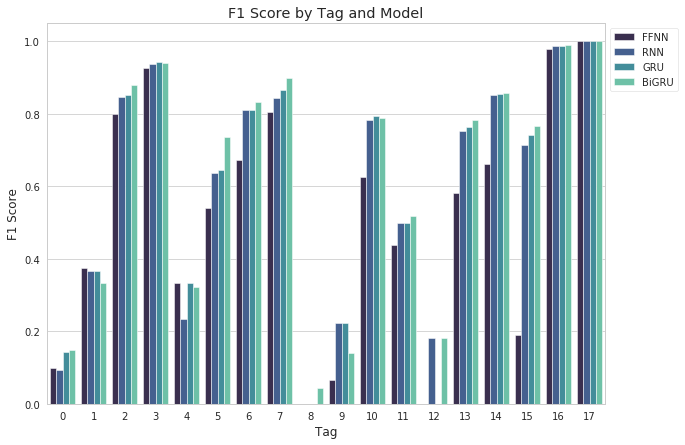

In [60]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize = (10,7))
sns.barplot(f1_scores['tag'], f1_scores['score'], hue = f1_scores['model'], palette = 'mako')
ax.legend(bbox_to_anchor = (1,1))
ax.set(xlabel = 'Tag', ylabel = 'F1 Score', title = 'F1 Score by Tag and Model');


**3.3** Briefly discuss the performance of each model

A higher f1 score corresponds to a higher quality model as it indicates a better combination of precision and recall. In general, we observe that the BiGRU typically outperforms the GRU across tags, which typically outperforms the RNN across tags, which outperforms the FFNN across tags. Although the tags show similar relative performance across models, some tags allow all models to perform much better. For instance, all models have an f1 score above 0.8 for tags 2, 3, 16, 17 while none score above 0.2 for tags 0 and 8. We also see that the discrepency between these models varies by tag. For instance, all models perform quite similarly on tags 3, 16, and 17, but the BiGRU vastly outperforms other models on tag 1. 

**3.4** Which tags have the lowest f1 score? For instance, you may find from the plot above that the test accuracy on "B-art", and "I-art" are very low (just an example, your case maybe different). Here is an example when models failed to predict these tags right

<img src="data/B_art.png" alt="drawing" width="600"/>

In [61]:
[idx2tag[tag] for tag in [0,8]]

['B-art', 'I-art']

Tags 0 and 8, which correspond to "beginning-art" and "inside-art" have the lowest f1 scores. 

**3.5** Write functions to output another example in which the tags of the lowest accuracy were predicted wrong in a sentence (include both "B-xxx" and "I-xxx" tags). Store the results in a DataFrame (same format as the above example) and use styling functions below to print out your df.

In [62]:
# Find a sentence that all models miss
missed_by_all = set(np.arange(len(y_te)))
for i, model_name in enumerate(models):
    # load model
    model = load_keras_model('model_' + model_name)
    # make predictions
    y_pred = to_categorical(model.predict_classes(X_te))
    # see where it missed tag 8
    missed_sentences_8 = np.argwhere( (y_te[:,:,8] == 1) & (y_pred[:,:,8] == 0))[:,0]
    # see where it missed tag 0
    missed_sentences_0 = np.argwhere( (y_te[:,:,0] == 1) & (y_pred[:,:,0] == 0))[:,0]
    # get intersection (within model)
    missed_sentence_both = set(missed_sentences_8).intersection(missed_sentences_0) # sentences missed by both
    # get intersection (across models)
    missed_by_all = missed_by_all.intersection(missed_sentence_both)
    
missed_by_all_index = list(missed_by_all)[0] # index 
missed_by_all_tokens = X_te[missed_by_all_index].reshape(1,-1) # X_te for that row

In [63]:
# Combine that sentence into a DF 
data_test_sentence_idx = data_test.sentence_idx.unique()[missed_by_all_index]
data_test_missed_by_all = data_test[data_test['sentence_idx'] == data_test_sentence_idx]


columns = ['Word','y_true','baseline','FFNN','RNN','GRU','BiGRU']
missed_df = pd.DataFrame(index = data_test_missed_by_all.index, columns = columns)
missed_df['Word'] = data_test_missed_by_all['Word']
missed_df['y_true'] = data_test_missed_by_all['Tag']
missed_df['baseline'] = [idx2tag[tag] for tag in baseline[np.array([words.index(word) for word in missed_df.Word])]]

for i, model_name in enumerate(models):
    # load model
    model = load_keras_model('model_' + model_name)
    # make prediction
    y_pred = model.predict_classes(missed_by_all_tokens).reshape(-1)
    y_pred_tags = [idx2tag[tag] for tag in y_pred]
    # add in 
    missed_df[model_name] = y_pred_tags[:len(missed_df)]


In [64]:
# style it
def correct_classification(s):
    y_true = s['y_true']
    is_true = s == y_true
    is_true[0] = True
    return ['color: red' if not v else '' for v in is_true]
missed_df.style.apply(axis = 1, func = correct_classification)

,Word,y_true,baseline,FFNN,RNN,GRU,BiGRU
468531,Gore,B-per,I-per,I-per,B-per,B-per,B-per
468532,won,O,O,O,O,O,O
468533,the,O,O,O,O,O,O
468534,Nobel,B-art,B-org,B-org,B-org,B-org,B-org
468535,Peace,I-art,I-org,I-org,I-org,I-org,I-org
468536,prize,O,O,O,O,I-org,O
468537,last,O,O,O,O,O,O
468538,year,O,O,O,O,O,O
468539,for,O,O,O,O,O,O
468540,his,O,O,O,O,O,O


**3.6** Choose one of the most promising models you have built, improve this model to achieve an f1 score higher than 0.8 for as many tags as possible (you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of NN, a different optimizer, etc.)

In [65]:
mod = Sequential()
mod.add(Embedding(n_words, dim_embed, input_length = max_len))
mod.add(BatchNormalization(axis=1, momentum=0.2))
mod.add(Dropout(.1))
mod.add(Bidirectional(GRU(n_units, return_sequences = 1)))
mod.add(TimeDistributed(Dense(n_tags, activation = 'softmax')))
mod.compile(optimizer = 'rmsprop', loss = loss)

history = mod.fit(X_tr, y_tr, batch_size=64, epochs=4, validation_split=validation_split, verbose=verbose)
store_keras_model(mod, 'bestmod')

Train on 38847 samples, validate on 4317 samples
Epoch 1/4
38847/38847 [==============================] - 44s 1ms/sample - loss: 0.0522 - val_loss: 0.0240
Epoch 2/4
38847/38847 [==============================] - 38s 986us/sample - loss: 0.0205 - val_loss: 0.0217
Epoch 3/4
38847/38847 [==============================] - 38s 986us/sample - loss: 0.0171 - val_loss: 0.0218
Epoch 4/4
38847/38847 [==============================] - 38s 977us/sample - loss: 0.0149 - val_loss: 0.0218
Saved model to disk


In [66]:
# ATTEMPTING TO RE-WEIGHT 
# from sklearn.utils import class_weight
# y_not_hot = data.Tag.apply(lambda x: tag2idx[x])
# class_weights = class_weight.compute_class_weight('balanced', np.sort(y_not_hot.unique()), y_not_hot)
# class_weights_dict = dict(zip(np.arange(len(class_weights)), class_weights))
# class_weights_dict[17] = class_weights_dict[16] # TODO: re-weight

# tags = []
# for sentence in y_tr:
#     for word in sentence:
#         tags.append([np.where(word == 1)[0][0]])
# tags = np.array(tags).reshape(-1)

# class_weights = class_weight.compute_class_weight('balanced', np.arange(n_tags),tags)
# class_weights_dict = dict(zip(np.arange(n_tags), class_weights))
# plz = np.array([class_weights_dict[i] for i in tags]).reshape(len(y_tr), -1)

# mod = Sequential()
# mod.add(Embedding(n_words, dim_embed, input_length = max_len))
# mod.add(BatchNormalization(axis=1, momentum=0.09))
# mod.add(Dropout(.1))
# mod.add(Bidirectional(GRU(n_units, return_sequences = 1)))
# mod.add(TimeDistributed(Dense(n_tags, use_bias = False)))
# mod.add(tf.keras.layers.Activation('softmax'))
# mod.compile(optimizer = 'rmsprop', loss = loss, sample_weight_mode = 'temporal')
# history = mod.fit(X_tr,
#                   y_tr,
#                   batch_size=512,
#                   epochs=10,
#                   validation_split = validation_split,
#                   verbose=verbose,
#                   sample_weight = plz)
                  

/usr/share/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


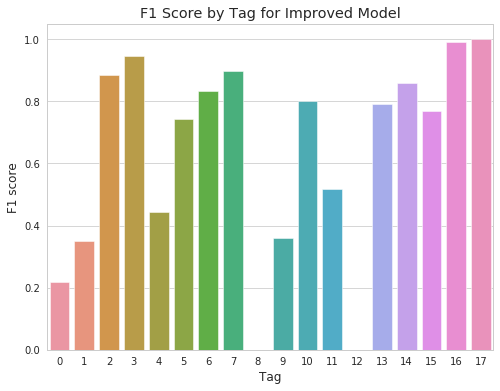

In [67]:
y_pred = to_categorical(mod.predict_classes(X_te))
f1_scores = []
for tag in range(n_tags):
    f1_scores.append(f1_score(y_te[:,:,tag].reshape(-1), y_pred[:,:,tag].reshape(-1)))

fig, ax = plt.subplots(figsize = (8,6))
sns.barplot(np.arange(n_tags), f1_scores)
ax.set(xlabel = 'Tag', ylabel = 'F1 score', title = 'F1 Score by Tag for Improved Model');

**3.7** Explain why you chose to change certain elements of the model and how effective these adjustments were.

 We chose to add batch normalization to the BiGRU because it helps to make the distributions of the activations at each layer similar to each other. This is necessary because the weights and the biases change after each layer and batch normalization serves essentially as a method of standardization during training, which can help to reduce overfitting and improve training.
 
 The modifications to the model only improve the validation loss and F1 scores slightly. 